# Hack For Good 2022 - Telefónica
## **Combo Lution**

### Importación de librerías

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import shutil
import zipfile
import glob

In [28]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

### Declaración de funciones

In [29]:
def scan_picture(path_to_picture):
    img = tf.io.read_file(path_to_picture)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    img = img/255.
    return img

In [30]:
def make_prediction(model_,path_to_picture):
    picture = scan_picture(path_to_picture)
    return model_.predict(tf.expand_dims(picture, axis=0))

In [31]:
def create_and_compile_model(url,number_of_classes=5):
  feature_extractor_layer = hub.KerasLayer(url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dropout(0.5),
    layers.Dense(number_of_classes, activation="softmax", name="output_layer")
  ])
  
  model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
  return model

In [8]:
def create_model_dense(model_url, num_classes=5):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(300),
    layers.Dense(150),
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

In [32]:
def plot_results(history):

  loss = history.history["loss"]
  accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

### Comprobamos qué tarjeta gráfica nos da Google 😀

In [33]:
!nvidia-smi

Sat Oct 22 10:49:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |   9016MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Descargamos el dataset que cuidadosamente ha elaborado el equipo

In [34]:
!wget https://transfer.sh/get/nyuuuN/DatasetH4G.zip

--2022-10-22 10:49:53--  https://transfer.sh/get/nyuuuN/DatasetH4G.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3917523194 (3.6G) [application/zip]
Saving to: ‘DatasetH4G.zip’

DatasetH4G.zip      100%[===================>]   3.65G  20.6MB/s    in 3m 49s  

2022-10-22 10:53:43 (16.3 MB/s) - ‘DatasetH4G.zip’ saved [3917523194/3917523194]



### Descomprimimos el dataset

In [35]:
zip_ref = zipfile.ZipFile('/content/DatasetH4G.zip')
zip_ref.extractall()
zip_ref.close()

### Cargamos los datos en sus correspondientes generadores

In [37]:
data_dir = "/content/DatasetH4G"

train_datagen_cont = ImageDataGenerator(rescale=1/255.,
                                        validation_split=0.35,
                                        )

print(">> Training images:")
training_data = train_datagen_cont.flow_from_directory(data_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical",
                                                          subset="training",
                                                          shuffle=True
                                                          )

print(">> Testing images:")
validation_data = train_datagen_cont.flow_from_directory(data_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical",
                                             subset="validation")

>> Training images:
Found 12472 images belonging to 6 classes.
>> Testing images:
Found 6713 images belonging to 6 classes.


### Creamos generadores con las imágenes distorsionadas para aumentar la capacidad de generalización de la red

In [38]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             width_shift_range=0.2,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory('/content/DatasetH4G',
                                                                   target_size=(512, 384),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 19185 images belonging to 6 classes.


### Importamos RESNET V2 50 para aplicar aprendizaje por transferencia

In [39]:
trained_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [40]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [41]:
resnet_model = create_and_compile_model(trained_model_url,6)

### **¡Entrenamos!**

In [42]:
resnet_history = resnet_model.fit(training_data,
                                  epochs=5,
                                  steps_per_epoch=len(training_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  shuffle=True)

Epoch 1/5
390/390 [==============================] - 443s 1s/step - loss: 0.4750 - accuracy: 0.8411 - val_loss: 1.0206 - val_accuracy: 0.7856
Epoch 2/5
390/390 [==============================] - 428s 1s/step - loss: 0.2448 - accuracy: 0.9120 - val_loss: 1.1834 - val_accuracy: 0.7919
Epoch 3/5
390/390 [==============================] - 418s 1s/step - loss: 0.2109 - accuracy: 0.9234 - val_loss: 1.0354 - val_accuracy: 0.7982
Epoch 4/5
390/390 [==============================] - 432s 1s/step - loss: 0.1934 - accuracy: 0.9298 - val_loss: 1.0147 - val_accuracy: 0.8020
Epoch 5/5
390/390 [==============================] - 419s 1s/step - loss: 0.1964 - accuracy: 0.9274 - val_loss: 1.1119 - val_accuracy: 0.8023


### Observamos los resultados del entrenamiento

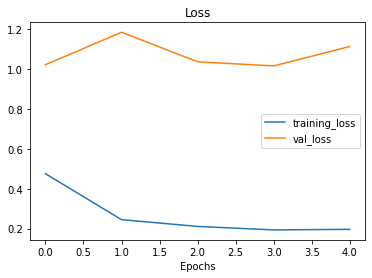

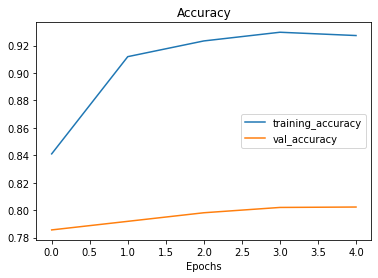

In [43]:
plot_results(resnet_history)


#### Observamos que el modelo sufre overfitting aunque los resultados son prometedores.

In [44]:
pred = make_prediction(resnet_model,'/content/fototest.jpg')
pred

1/1 [==============================] - 0s 494ms/step


array([[9.7392029e-01, 9.4371462e-05, 2.6068274e-06, 4.2391162e-07,
        2.2833831e-04, 2.5753967e-02]], dtype=float32)

In [ ]:
files = glob.glob('pruebaIMG/*')
for f in files:
  pred = make_prediction(resnet_model,f)
  print(pred,f,'\n',pred.round())

1/1 [==============================] - 0s 39ms/step
[[2.2651415e-04 9.9975961e-01 1.2140516e-05 1.6804542e-07 5.3434883e-07
  9.6028907e-07]] pruebaIMG/caja.jpeg 
 [[0. 1. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 44ms/step
[[6.0610720e-03 9.6839858e-04 5.5039617e-08 9.6828830e-01 2.7138347e-04
  2.4410753e-02]] pruebaIMG/uvas.jpeg 
 [[0. 0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 47ms/step
[[2.3578776e-01 4.1151813e-01 1.2470073e-01 8.8855617e-05 7.8827180e-02
  1.4907733e-01]] pruebaIMG/rotulador.jpeg 
 [[0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 41ms/step
[[9.8738724e-01 2.2550372e-05 2.6837080e-07 9.9976623e-06 4.9211364e-04
  1.2087809e-02]] pruebaIMG/botella.jpeg 
 [[1. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 41ms/step
[[2.0721199e-01 1.6596550e-01 3.7746559e-05 2.8126612e-01 5.9758317e-02
  2.8576034e-01]] pruebaIMG/emboltorio.jpeg 
 [[0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 25ms/step
[[9.

#### ¡Predice correctamente!

In [47]:
resnet_model.save('modelo16')

In [48]:
shutil.make_archive('modelo16', 'zip', 'modelo16')

'/content/modelo16.zip'

In [50]:
!curl --upload-file /content/modelo16.zip https://transfer.sh/modelo16.zip https://transfer.sh/sFhzGm/modelo16.zip

https://transfer.sh/BgvBQm/modelo16.zipNot Found
